In [16]:
from ultralytics import YOLO
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import torch
from PIL import Image
from strhub.data.module import SceneTextDataModule

%matplotlib inline

os.environ['USE_TORCH'] = '1'

# Load model
model = YOLO("./new_models/best.pt")
reader = easyocr.Reader(['en'], gpu=True)

# Load model and image transforms
parseq = torch.hub.load('baudm/parseq', 'parseq', pretrained=True).eval()
img_transform = SceneTextDataModule.get_transform(parseq.hparams.img_size)


import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Using cache found in C:\Users\lucki/.cache\torch\hub\baudm_parseq_main


Looking for C:\Users\lucki\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\lucki\.keras-ocr\crnn_kurapan.h5


In [64]:
# from PIL
im1 = Image.open(
    r"D:\WORK\Personal\US-Driver-License-data-extraction\DATASET\DL America\licenses\Alabama's.jpg")

# from list of PIL/ndarray
results = model.predict(source=im1, augment=True)


0: 416x640 1 address, 1 dob, 1 name, 1 state, 159.9ms
Speed: 1.0ms preprocess, 159.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


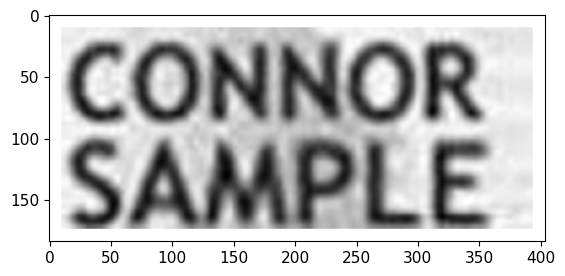

EasyOCR :  ['CONNOR', 'SAMPLE']
1/1 [==============================] - 0s 74ms/step
Keras-OCR :  ['connor', 'sample']
Parseq :  ['CONNOR']


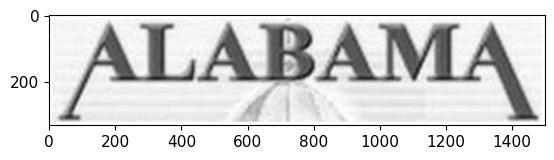

EasyOCR :  ['ALABAMA']
1/1 [==============================] - 0s 40ms/step
Keras-OCR :  ['alabama']
Parseq :  ['ALABAMA']


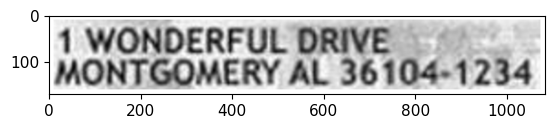

EasyOCR :  ['WONDERFUL DRIVE', 'MONTGOMERY AL 36104-1234']
1/1 [==============================] - 0s 51ms/step
Keras-OCR :  ['wondereul', 'drive', '1', '361041234', 'montgomery', 'al']
Parseq :  ['MONTGOMERYAL36104-1234']


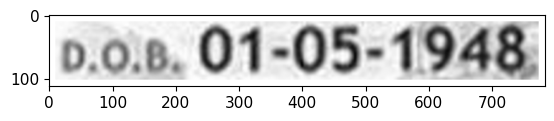

EasyOCR :  ['0.0.0.01-05-1948']
1/1 [==============================] - 0s 43ms/step
Keras-OCR :  ['8051948', '01', 'lb', 'dio']
Parseq :  ['D.O.8.01-05-1948']


In [65]:
keras_crop_imgs = []

image = None
images = None

boxes = results[0].boxes
for box in boxes:

    ### Image processing ###
    # crop each box
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    cropped = im1.crop((x1, y1, x2, y2))
    cropped = cropped.resize((cropped.width*4, cropped.height*4))

    # add padding to cropped image 
    cropped = np.array(cropped)

    # make image black and white
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # convert to 3 channels
    cropped = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

    cropped = cv2.copyMakeBorder(cropped, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    cropped = Image.fromarray(cropped)

    plt.imshow(cropped)
    plt.show()


    ### OCR ###

    # 1. EasyOCR
    print("EasyOCR : ", reader.readtext(np.array(cropped), detail=0))

    # 2. keras-ocr
    images = [keras_ocr.tools.read(np.asarray(cropped))]

    prediction_groups = pipeline.recognize(images)

    print("Keras-OCR : ", [x[0] for x in prediction_groups[0]])

    # 3. Parseq
    logits = parseq(img_transform(cropped).unsqueeze(0))
    logits.shape  # torch.Size([1, 26, 95]), 94 characters + [EOS] symbol

    # greedy decoding
    pred = logits.softmax(-1)
    label, confidence = parseq.tokenizer.decode(pred)
    print("Parseq : ", label)



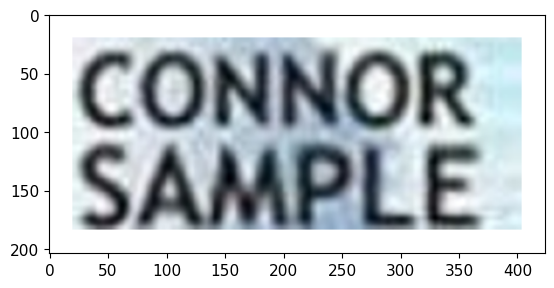

Threshold value : 50
['CONNOK', 'SAMPLE']
Threshold value : 60
['CONNOR', 'SAMPLE']
Threshold value : 70
['CONNOR', 'SAMPLE']
Threshold value : 80
['CONNOR', 'SAMPLE']
Threshold value : 90
['CONNOR', 'SAMPLE']
Threshold value : 100
['CONNOR', 'SAMPLE']
Threshold value : 110
['CONNOR', 'SAMPLE']
Threshold value : 120
['CONNOR', 'SAMPLE']
Threshold value : 130
['CONNOR', 'SAMPLE']
Threshold value : 140
['CONNOR', 'SAMPLE']
Threshold value : 150
['CONNOR', 'SAMPLE']
Threshold value : 160
['CONNOR', 'SANPLE']
Threshold value : 170
['CONNOR', 'SAMPLE']
Threshold value : 180
['CONNOR', 'SAMELE']
Threshold value : 190
['CONNOR', 'SAYTLE']


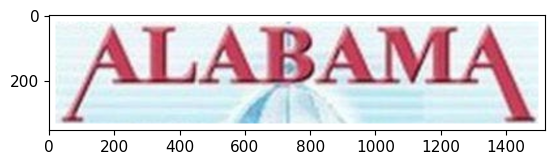

Threshold value : 50
['1 :', '{1']
Threshold value : 60
['ARAMC']
Threshold value : 70
['4 LABAV_']
Threshold value : 80
['ALABAMA']
Threshold value : 90
['ALABAMA']
Threshold value : 100
['ALABAMA']
Threshold value : 110
['ALABAMA']
Threshold value : 120
['ALABAMA']
Threshold value : 130
['ALABAMA']
Threshold value : 140
['ALABAMA']
Threshold value : 150
['ALABAMA']
Threshold value : 160
['ALABAMA']
Threshold value : 170
['ALABAMA']
Threshold value : 180
['ALABAMA']
Threshold value : 190
['ALABAMA']


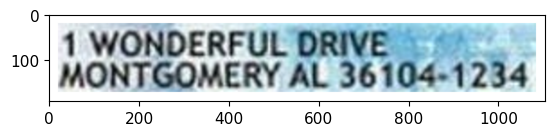

Threshold value : 50
['{cnsiphtW>v', "'CMTcvl*", 'AL WO:', '1,:']
Threshold value : 60
['MCNDERFUiJRVz', "'ONTGOVL? Al }6io: 1234"]
Threshold value : 70
['MONDERFUL DRIVE', 'BONTGOvL? AL 36i0: 1234']
Threshold value : 80
['MONDERFUL DRIVE', 'AXONTGOXCRY KL 36104 1234']
Threshold value : 90
['WONDERFUL DRIVE', 'HAONTGOMCRY AL 3610:.1234']
Threshold value : 100
['WONDERFUL DRIVE', 'DONTGOMERY AL 36104.1234']
Threshold value : 110
['1', 'WONDERFUL DRIVE `', 'MONTGOMERY AL 36104.1234']
Threshold value : 120
['1', 'WONDERFUL DRIVE', 'MONTGoMERY AL 36104.1234']
Threshold value : 130
['1', 'WONDERFUL DRivE', 'MONTgomERY AL 36104.1234']
Threshold value : 140
['1 WONDERFUL Drive', 'MONTGomeRY AL 36104.1234']
Threshold value : 150
['1', 'WONDERFUL DRIVE', 'MONTGOMERYAL 36104-1234']
Threshold value : 160
['1 WONDERFUL DRNVE', 'MONTGOMERY AL 361041234']
Threshold value : 170
['1', 'WONDERFUL DrNE', 'MONTCOMERY AL 3610441234']
Threshold value : 180
['WONDERFul DRN:', 'MONTQOMERY AL 3610+1']
Thresho

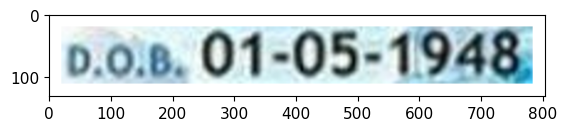

Threshold value : 50
01-05-1948
Threshold value : 60
01-05-1948
Threshold value : 70
01-05-1948
Threshold value : 80
['01-05-1948']
Threshold value : 90
['01-05-1948']
Threshold value : 100
['01-05-1948']
Threshold value : 110
['01-05-1948']
Threshold value : 120
['01-05-1948']
Threshold value : 130
['01-05-1948']
Threshold value : 140
['01-05-1948']
Threshold value : 150
['01-05-1948']
Threshold value : 160
['01-05-1948']
Threshold value : 170
01-05-1948
Threshold value : 180
01-05-1948
Threshold value : 190
01-05-1948


In [72]:
boxes = results[0].boxes
for box in boxes:
    names = {0: 'address', 1: 'dob', 2: 'name', 3: 'state'}

    ### Image processing ###
    # crop each box
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    cropped = im1.crop((x1, y1, x2, y2))
    cropped = cropped.resize((cropped.width*4, cropped.height*4))

    # add padding to cropped image 
    cropped = np.array(cropped)

    cropped = cv2.copyMakeBorder(cropped, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    cropped = Image.fromarray(cropped)

    plt.imshow(cropped)
    plt.show()

    # test the threshold values in increasing order to get the best result
    for i in range(50, 200, 10):
        print("Threshold value : {}".format(i))
        _, thresh = cv2.threshold(np.array(cropped), i, 255, cv2.THRESH_BINARY)
        # plt.imshow(thresh)
        # plt.show()

        # run easyOCR on each cropped box and match with the class name
        temp = reader.readtext(np.array(thresh),
                                detail=0,
                                # allowlist for dob
                                allowlist='0123456789/-' if int(box.cls[0]) == 1 else None,
                                )
        if temp:
            # Name processing
            if int(box.cls[0]) == 2 and len(temp) > 3:
                temp.pop(0); temp.pop(1)
                print(temp)

            # DOB processing
            elif int(box.cls[0]) == 1:
                if len(temp) > 1:
                    temp.pop(0)
                    print(temp)
                else:
                    temp = temp[0][-10:]
                    print(temp)

            else:
                print(temp)
